In [6]:
import os
import sys
import pandas as pd


In [7]:
import os, sys
import pandas as pd


In [8]:
DATA_PATH = "../data/raw/training.1600000.processed.noemoticon.csv"

df = pd.read_csv(DATA_PATH, encoding="latin-1", header=None)
df.columns = ["target","ids","date","flag","user","text"]

df = df[["target","text"]].dropna()
df["sentiment"] = df["target"].map({0:0, 4:1})
df = df.drop(columns=["target"])

df.shape


(1600000, 2)

In [9]:
df_small = (
    df.groupby("sentiment", group_keys=False)
      .sample(n=10000, random_state=42)
      .reset_index(drop=True)
)

df_small.shape, df_small["sentiment"].value_counts()


((20000, 2),
 sentiment
 0    10000
 1    10000
 Name: count, dtype: int64)

In [10]:
import os, sys
PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)


In [11]:
from src.preprocessing import split_data

X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_small)

train_df = pd.DataFrame({"text": X_train.values, "label": y_train.values})
val_df   = pd.DataFrame({"text": X_val.values,   "label": y_val.values})
test_df  = pd.DataFrame({"text": X_test.values,  "label": y_test.values})

train_df.shape, val_df.shape, test_df.shape


((16000, 2), (2000, 2), (2000, 2))

In [12]:
from datasets import Dataset
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=64)

train_ds = train_ds.map(tokenize_fn, batched=True, remove_columns=["text"])
val_ds   = val_ds.map(tokenize_fn, batched=True, remove_columns=["text"])
test_ds  = test_ds.map(tokenize_fn, batched=True, remove_columns=["text"])

train_ds.set_format("torch")
val_ds.set_format("torch")
test_ds.set_format("torch")


/Users/ismayilmohsumov/Documents/yash uni/nlp/sentiment-analysis/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [13]:
import numpy as np
import evaluate
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

acc = evaluate.load("accuracy")
f1  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="binary")["f1"],
    }

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

args = TrainingArguments(
    output_dir="../outputs/distilbert_sentiment_20k",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=25,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ismayilmohsumov/Documents/yash uni/nlp/sentiment-analysis/venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.438100,0.403110,0.819500,0.820130


TrainOutput(global_step=500, training_loss=0.47747432327270506, metrics={'train_runtime': 170.2886, 'train_samples_per_second': 93.958, 'train_steps_per_second': 2.936, 'total_flos': 264934797312000.0, 'train_loss': 0.47747432327270506, 'epoch': 1.0})

In [14]:
trainer.evaluate(test_ds)


/Users/ismayilmohsumov/Documents/yash uni/nlp/sentiment-analysis/venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.4192639887332916,
 'eval_accuracy': 0.808,
 'eval_f1': 0.8110236220472441,
 'eval_runtime': 8.1579,
 'eval_samples_per_second': 245.161,
 'eval_steps_per_second': 3.923,
 'epoch': 1.0}

In [15]:
trainer.save_model("../outputs/distilbert_sentiment_20k/best_model")
tokenizer.save_pretrained("../outputs/distilbert_sentiment_20k/best_model")


('../outputs/distilbert_sentiment_20k/best_model/tokenizer_config.json',
 '../outputs/distilbert_sentiment_20k/best_model/special_tokens_map.json',
 '../outputs/distilbert_sentiment_20k/best_model/vocab.txt',
 '../outputs/distilbert_sentiment_20k/best_model/added_tokens.json',
 '../outputs/distilbert_sentiment_20k/best_model/tokenizer.json')

In [16]:
import torch
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=trainer.model, tokenizer=tokenizer, device=-1)

sample = test_df.sample(200, random_state=42).reset_index(drop=True)
preds = pipe(sample["text"].tolist(), truncation=True, max_length=64)
pred_labels = [1 if p["label"].endswith("1") else 0 for p in preds]
sample["pred"] = pred_labels
sample["correct"] = (sample["pred"] == sample["label"])

sample[~sample["correct"]].head(10)


Device set to use mps:0


,text,label,pred,correct
6,@bonnie_booo it ain't gonna happen...i'v got g...,1,0,False
9,Chillin @ jareds and corys apartment. Level 32...,0,1,False
11,@RobyLa i saw this hotpink G-shock &amp; i was...,0,1,False
13,Heading to the Carpathians in about 1.5 hours....,0,1,False
15,Reading about quitting smoking. I smoke a pack...,0,1,False
16,"@tommcfly mmm Tasty, you'r making me hungry now",0,1,False
22,yeah Twitter is back to work after maintenance,1,0,False
24,In Atlanta waiting for my flight to Montreal.,0,1,False
27,@Gooshy1 So tempting to come back tonight,0,1,False
43,@rakelgerero coaching???? haha i knew you'd th...,0,1,False


In [17]:
import numpy as np
import pandas as pd

pred_out = trainer.predict(test_ds)
logits = pred_out.predictions
probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)  # softmax
pred = logits.argmax(axis=1)

results = test_df.copy().reset_index(drop=True)
results["pred"] = pred
results["correct"] = (results["pred"] == results["label"])
results["prob_pos"] = probs[:, 1]
results["confidence"] = probs.max(axis=1)

results.head()


/Users/ismayilmohsumov/Documents/yash uni/nlp/sentiment-analysis/venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,text,label,pred,correct,prob_pos,confidence
0,@mileycyrus If there is anything I can do to h...,0,1,False,0.720927,0.720927
1,F1 teams set to breakaway from the championshi...,0,1,False,0.649674,0.649674
2,Sooo...one day on the beach and i am completel...,0,1,False,0.508111,0.508111
3,@iBANG im goin to try my best,1,1,True,0.859819,0.859819
4,@xXAudioMonkXx hey it's us.... Thought it was...,1,1,True,0.936005,0.936005


In [18]:
results[results["correct"] == False].sample(30, random_state=42)[["text","label","pred","confidence","prob_pos"]]


,text,label,pred,confidence,prob_pos
1395,i got good meds... i will b at school late. ...,1,0,0.896490,0.103510
1288,"i'm not crazy, i'm just obsessed",1,0,0.686086,0.313914
1829,shares http://tinyurl.com/oxhomp (Venetia Phai...,0,1,0.823763,0.823763
1711,Went to Watergate last night. Awesome club. 12...,0,1,0.664577,0.664577
286,So tired. Need to get some rest for tomorrow!,1,0,0.889518,0.110482
1943,I wanna go home. The home where my heart it t...,0,1,0.580093,0.580093
154,"@Thummper08 I try my best , some think I shoul...",0,1,0.630960,0.630960
559,@efortiz what did you end up getting pierced? ...,1,0,0.920320,0.079680
1966,"@hideawayxx wow, that really is a coincidence ...",0,1,0.641080,0.641080
1216,Just got back from Midtown. @Lands I called yo...,0,1,0.754156,0.754156


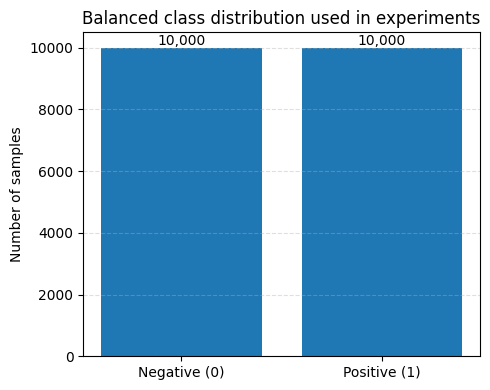

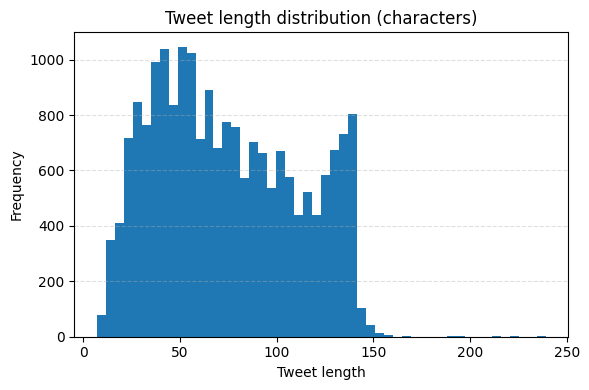

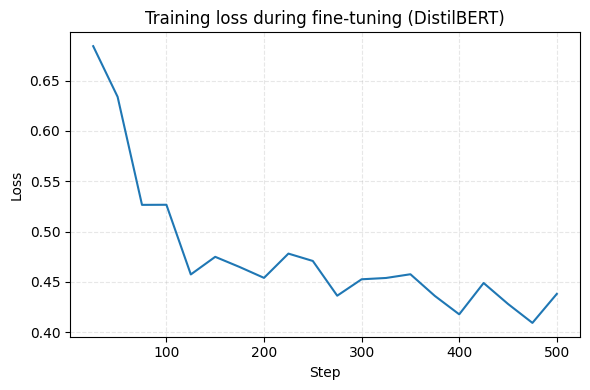

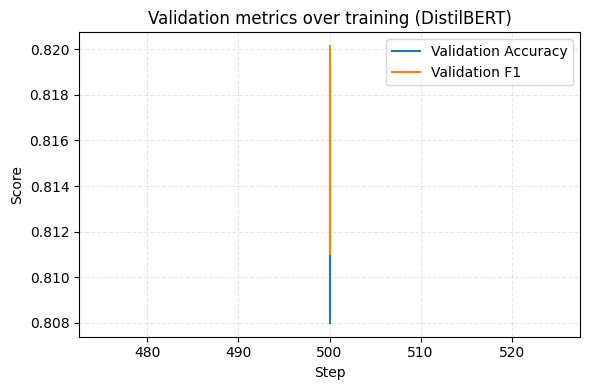

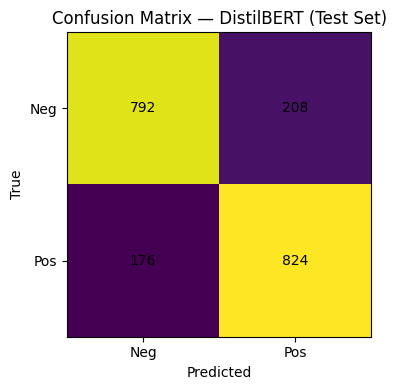

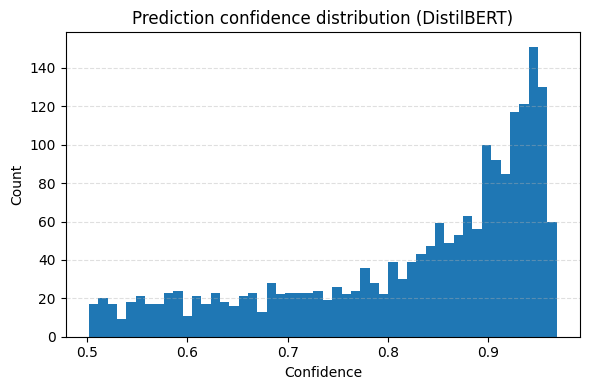

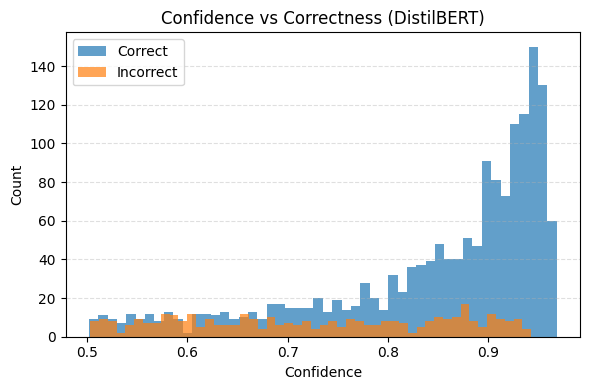

DistilBERT Test Accuracy: 0.808

Classification Report (DistilBERT, Test):
              precision    recall  f1-score   support

           0     0.8182    0.7920    0.8049      1000
           1     0.7984    0.8240    0.8110      1000

    accuracy                         0.8080      2000
   macro avg     0.8083    0.8080    0.8080      2000
weighted avg     0.8083    0.8080    0.8080      2000


Saved figures to: /Users/ismayilmohsumov/Documents/yash uni/nlp/sentiment-analysis/figures


In [19]:
# =========================
# PAPER FIGURES (EXTENSION)
# =========================

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 1) Create figures directory
FIG_DIR = Path("../figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(name: str):
    """Save current matplotlib figure to ../figures/ in paper-ready quality."""
    plt.tight_layout()
    plt.savefig(FIG_DIR / name, dpi=300, bbox_inches="tight")

# -------------------------
# FIGURE 1: Balanced class distribution (df_small)
# -------------------------
counts_small = df_small["sentiment"].value_counts().sort_index()

plt.figure(figsize=(5, 4))
plt.bar(["Negative (0)", "Positive (1)"], counts_small.values)
plt.ylabel("Number of samples")
plt.title("Balanced class distribution used in experiments")
plt.grid(axis="y", linestyle="--", alpha=0.4)

for i, v in enumerate(counts_small.values):
    plt.text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=10)

savefig("fig1_class_distribution_balanced.png")
plt.show()

# -------------------------
# FIGURE 2: Tweet length distribution (df_small)
# -------------------------
tweet_len = df_small["text"].astype(str).str.len()

plt.figure(figsize=(6, 4))
plt.hist(tweet_len, bins=50)
plt.title("Tweet length distribution (characters)")
plt.xlabel("Tweet length")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.4)

savefig("fig2_tweet_length_hist.png")
plt.show()

# -------------------------
# FIGURE 3: Training loss curve (DistilBERT)
# -------------------------
log_history = trainer.state.log_history

steps, losses = [], []
eval_steps, eval_acc, eval_f1 = [], [], []

for row in log_history:
    if "loss" in row and "step" in row:
        steps.append(row["step"])
        losses.append(row["loss"])
    if "eval_accuracy" in row and "step" in row:
        eval_steps.append(row["step"])
        eval_acc.append(row["eval_accuracy"])
        eval_f1.append(row.get("eval_f1", None))

if len(steps) > 0:
    plt.figure(figsize=(6, 4))
    plt.plot(steps, losses)
    plt.title("Training loss during fine-tuning (DistilBERT)")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid(True, linestyle="--", alpha=0.3)

    savefig("fig3_training_loss_curve.png")
    plt.show()

# Optional: validation metrics curve (only if available)
if len(eval_steps) > 0:
    plt.figure(figsize=(6, 4))
    plt.plot(eval_steps, eval_acc, label="Validation Accuracy")
    if all(v is not None for v in eval_f1):
        plt.plot(eval_steps, eval_f1, label="Validation F1")

    plt.title("Validation metrics over training (DistilBERT)")
    plt.xlabel("Step")
    plt.ylabel("Score")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()

    savefig("fig4_validation_metrics_curve.png")
    plt.show()

# -------------------------
# FIGURE 4: Confusion matrix (DistilBERT test)
# -------------------------
y_true = results["label"].values
y_pred = results["pred"].values
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.title("Confusion Matrix — DistilBERT (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0, 1], ["Neg", "Pos"])
plt.yticks([0, 1], ["Neg", "Pos"])

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

savefig("fig5_confusion_matrix_distilbert.png")
plt.show()

# -------------------------
# FIGURE 5: Confidence distribution + correct vs incorrect
# -------------------------
plt.figure(figsize=(6, 4))
plt.hist(results["confidence"], bins=50)
plt.title("Prediction confidence distribution (DistilBERT)")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.4)

savefig("fig6_confidence_distribution.png")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(results.loc[results["correct"] == True, "confidence"], bins=50, alpha=0.7, label="Correct")
plt.hist(results.loc[results["correct"] == False, "confidence"], bins=50, alpha=0.7, label="Incorrect")
plt.title("Confidence vs Correctness (DistilBERT)")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()

savefig("fig7_confidence_correct_vs_incorrect.png")
plt.show()

# -------------------------
# TABLE 1: Top errors (export for paper)
# -------------------------
errors = results[results["correct"] == False].copy()
errors = errors.sort_values("confidence", ascending=False)
errors_table = errors[["text", "label", "pred", "confidence", "prob_pos"]].head(15)

# Display in notebook
errors_table

# Save for paper appendix / analysis
errors_table.to_csv(FIG_DIR / "table1_top_errors_distilbert.csv", index=False)

# -------------------------
# (Optional) Print summary metrics (text you can cite in paper)
# -------------------------
acc_test = accuracy_score(y_true, y_pred)
print("DistilBERT Test Accuracy:", acc_test)
print("\nClassification Report (DistilBERT, Test):")
print(classification_report(y_true, y_pred, digits=4))

print(f"\nSaved figures to: {FIG_DIR.resolve()}")
